In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from pprint import pprint
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

# map district name to district number
district_mapping_path = "../airflow/dags/data/districts.xlsx"

district_mapping = pd.read_excel(district_mapping_path)


def get_district_name(district_no):
    return district_mapping[district_mapping["Postal District"] == district_no][
        "General Location"
    ].values[0]

# Import Previous Files

In [147]:
# Import all previous files
# open pickle
train_df_dict = pd.read_pickle('data/train_df_dict.pkl')
train_df_dict_L = pd.read_pickle('data/train_df_dict_L.pkl')
test_df_dict = pd.read_pickle('data/test_df_dict.pkl')

lookback = 6

# import resale_flat_transactions_clean
resale_flat_transactions_clean = pd.read_csv('data/resale_flat_transactions_clean.csv')

# import features 
all_district_var_ts = pd.read_pickle('data/all_district_var_ts.pkl')

# replace NaN values with 0 since we are using LSTM
# Mask layer will mask the 0 values
# merge the train set with the features
train_lstm_df_dict = {}
for district_no, district_df in train_df_dict.items():
    train_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    train_lstm_df_dict[district_no] = train_lstm_df_dict[district_no].fillna(0)

train_lstm_df_dict_L = {}
for district_no, district_df in train_df_dict_L.items():
    train_lstm_df_dict_L[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')

# merge the test set with the features
test_lstm_df_dict = {}
for district_no, district_df in test_df_dict.items():
    test_lstm_df_dict[district_no] = district_df.to_frame().merge(all_district_var_ts[district_no], left_index=True, right_index=True, how='left')
    # replace the NaN values with 0
    test_lstm_df_dict[district_no] = test_lstm_df_dict[district_no].fillna(0)


# Normalize the data for training

In [148]:
# Normalize the data
# create scalers for each district
scaler_dict = {}
for district_no, district_df in train_lstm_df_dict.items():
    scaler_dict[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict[district_no].fit(district_df)

# create scalers for each district
scaler_dict_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    scaler_dict_L[district_no] = MinMaxScaler(feature_range=(0, 1))
    scaler_dict_L[district_no].fit(district_df)

# transform the train set
train_lstm_df_dict_scaled = {}
for district_no, district_df in train_lstm_df_dict.items():
    train_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the train set
train_lstm_df_dict_scaled_L = {}
for district_no, district_df in train_lstm_df_dict_L.items():
    train_lstm_df_dict_scaled_L[district_no] = pd.DataFrame(
        scaler_dict_L[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# transform the test set
test_lstm_df_dict_scaled = {}
for district_no, district_df in test_lstm_df_dict.items():
    test_lstm_df_dict_scaled[district_no] = pd.DataFrame(
        scaler_dict[district_no].transform(district_df),
        columns=district_df.columns,
        index=district_df.index,
    )

# Format Data for LSTM

In [149]:
# convert all data 

lookback = 3
num_features = len(train_lstm_df_dict_scaled[1].columns)

# create dataset for each district
train_lstm_dataset_dict = {}
for district_no, district_df in train_lstm_df_dict_scaled.items():
    train_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
train_lstm_dataset_dict_L = {}
for district_no, district_df in train_lstm_df_dict_scaled_L.items():
    train_lstm_dataset_dict_L[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)

# create dataset for each district
test_lstm_dataset_dict = {}
for district_no, district_df in test_lstm_df_dict_scaled.items():
    test_lstm_dataset_dict[district_no] = TimeseriesGenerator(district_df.values, district_df.values, length=lookback, batch_size=1)


In [150]:
# check generator dimensions
for i in range(len(test_lstm_dataset_dict[1])):
    x, y = test_lstm_dataset_dict[1][i]
    print(x.shape, y.shape)
print(len(test_lstm_dataset_dict[1]))

len(test_lstm_df_dict_scaled[1])

(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
(1, 3, 9) (1, 9)
21


24

# LSTM Model on district 1

In [151]:
def fit_lstm(train):
    model = Sequential()
    model.add( 
        Masking(
            mask_value=0.,
            input_shape=(
                lookback,
                num_features,
            ),
        )
    ) # mask the 0 values
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(
        train,
        epochs=20,
        batch_size=8, 
        verbose=1 # type: ignore
    )

    return model



model_1 = fit_lstm(train_lstm_dataset_dict[1])


Epoch 1/20


2023-04-03 23:34:06.185703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:07.127347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:07.476540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:07.730373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:08.078232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:08.467566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:34:08.796895: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 14s 141ms/step - loss: 0.1672
Epoch 2/20
36/36 [==============================] - 3s 75ms/step - loss: 0.1488
Epoch 3/20
36/36 [==============================] - 3s 74ms/step - loss: 0.1482
Epoch 4/20
36/36 [==============================] - 3s 76ms/step - loss: 0.1459
Epoch 5/20
36/36 [==============================] - 3s 74ms/step - loss: 0.1431
Epoch 6/20
36/36 [==============================] - 3s 72ms/step - loss: 0.1436
Epoch 7/20
36/36 [==============================] - 3s 74ms/step - loss: 0.1422
Epoch 8/20
36/36 [==============================] - 3s 72ms/step - loss: 0.1416
Epoch 9/20
36/36 [==============================] - 3s 74ms/step - loss: 0.1402
Epoch 10/20
36/36 [==============================] - 3s 75ms/step - loss: 0.1403
Epoch 11/20
36/36 [==============================] - 3s 73ms/step - loss: 0.1386
Epoch 12/20
36/36 [==============================] - 3s 71ms/step - loss: 0.1378
Epoch 13/20
36/36 [===========================

## Get predictions and plot

In [152]:
# get the predictions
predictions = model_1.predict(test_lstm_dataset_dict[1])

print(predictions.shape) 
# number of predictions is 3 less than the number of test data because of the lookback. 
# This means that the predictions needs to be shifted by 3 months

# pad the predictions with 0 
predictions_padded = np.zeros((len(predictions), num_features)) # add dimension for the number of features
predictions_padded[:, 0] = predictions[:, 0] # fill the first column with the predictions

# inverse transform the predictions
predictions_inversed = scaler_dict[1].inverse_transform(predictions_padded) # correct shape for inverse transform

print(test_lstm_df_dict_scaled[1].shape) # test data shape


2023-04-03 23:35:06.091919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:06.622804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:06.824267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:07.018980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 4s 56ms/step
(21, 1)
(24, 9)


In [153]:
def evaluate_lstm(model, X_train, X_test, district_no, lookback):
    # make predictions
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    # pad the predictions
    yhat_train_padded = np.zeros((len(yhat_train), num_features))
    yhat_train_padded[:, 0] = yhat_train[:, 0]
    yhat_test_padded = np.zeros((len(yhat_test), num_features))
    yhat_test_padded[:, 0] = yhat_test_padded[:, 0]
    
    # inverse transform the predictions
    yhat_train_inversed = scaler_dict[district_no].inverse_transform(yhat_train_padded)
    yhat_test_inversed = scaler_dict[district_no].inverse_transform(yhat_test_padded)
    print("yhat train shape", yhat_train_inversed.shape)
    print("yhat test shape", yhat_test_inversed.shape)

    # take values only
    yhat_train_inversed = yhat_train_inversed[:, 0] 
    yhat_test_inversed = yhat_test_inversed[:, 0]

    # ground truth
    y_train = train_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    y_test = test_lstm_df_dict[district_no]['resale_price'].values[lookback:] # remove the first lookback months
    print("y train shape", y_train.shape)
    print("y test shape", y_test.shape)

    train_score = math.sqrt(mean_squared_error(y_train, yhat_train_inversed))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, yhat_test_inversed))
    print('Test Score: %.2f RMSE' % (test_score))

    try: 
        # set index of the predictions 
        yhat_train_df = pd.DataFrame(yhat_train_inversed, index=train_lstm_df_dict[1].index[lookback:])
        yhat_test_df = pd.DataFrame(yhat_test_inversed, index=test_lstm_df_dict[1].index[lookback:])
    except:
        print(f'model for district {district_no} cannot be evaluated')
        return None

    # plot baseline and predictions
    plt.plot(train_lstm_df_dict[district_no]['resale_price'], label="y_train", marker='o')
    plt.plot(test_lstm_df_dict[district_no]['resale_price'], label="y_test", marker='o')
    plt.plot(yhat_train_df, label="yhat_train", marker='o')
    plt.plot(yhat_test_df, label="yhat_test", marker='o')
    plt.legend()
    plt.show()

    return test_score


21/21 [==============================] - 0s 18ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 251819.99 RMSE
Test Score: 434867.74 RMSE


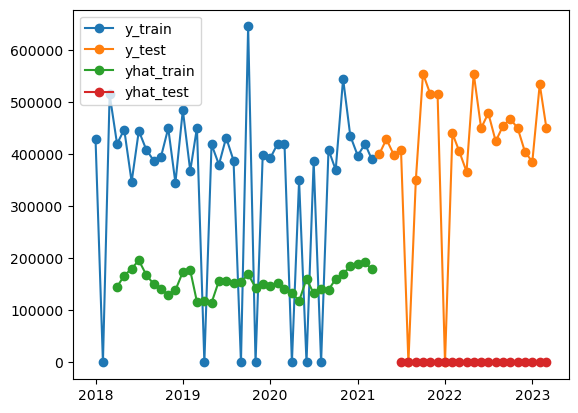

434867.7363236299

In [154]:
evaluate_lstm(
    model=model_1,
    X_train=train_lstm_dataset_dict[1],
    X_test=test_lstm_dataset_dict[1],
    district_no=1,
    lookback=lookback,
)


# LSTM on all districts

district_no 1
Epoch 1/20


2023-04-03 23:35:17.524872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:18.560960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:18.988329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:19.397688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:19.839545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:20.223036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:35:20.528992: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 15s 168ms/step - loss: 0.1706
Epoch 2/20
36/36 [==============================] - 3s 78ms/step - loss: 0.1494
Epoch 3/20
36/36 [==============================] - 3s 73ms/step - loss: 0.1465
Epoch 4/20
36/36 [==============================] - 3s 82ms/step - loss: 0.1444
Epoch 5/20
36/36 [==============================] - 3s 89ms/step - loss: 0.1437
Epoch 6/20
36/36 [==============================] - 4s 99ms/step - loss: 0.1435
Epoch 7/20
36/36 [==============================] - 3s 89ms/step - loss: 0.1428
Epoch 8/20
36/36 [==============================] - 3s 77ms/step - loss: 0.1419
Epoch 9/20
36/36 [==============================] - 3s 71ms/step - loss: 0.1407
Epoch 10/20
36/36 [==============================] - 3s 75ms/step - loss: 0.1391
Epoch 11/20
36/36 [==============================] - 3s 72ms/step - loss: 0.1386
Epoch 12/20
36/36 [==============================] - 3s 74ms/step - loss: 0.1421
Epoch 13/20
36/36 [===========================

2023-04-03 23:36:23.363829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:23.941032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:24.221417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:24.515368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 26ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 229306.15 RMSE
Test Score: 434867.74 RMSE


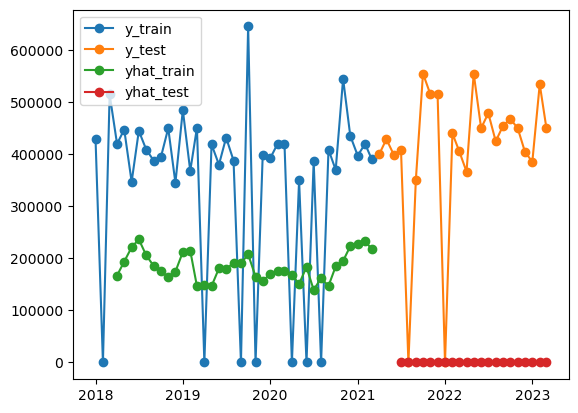

district_no 2
Epoch 1/20


2023-04-03 23:36:34.445946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:35.351120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:35.700183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:36.049974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:36.501959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:36.882789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:36:37.284114: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 12s 136ms/step - loss: 0.2195
Epoch 2/20
36/36 [==============================] - 2s 64ms/step - loss: 0.1811
Epoch 3/20
36/36 [==============================] - 2s 53ms/step - loss: 0.1779
Epoch 4/20
36/36 [==============================] - 2s 57ms/step - loss: 0.1770
Epoch 5/20
36/36 [==============================] - 2s 55ms/step - loss: 0.1779
Epoch 6/20
36/36 [==============================] - 2s 58ms/step - loss: 0.1767
Epoch 7/20
36/36 [==============================] - 2s 49ms/step - loss: 0.1773
Epoch 8/20
36/36 [==============================] - 2s 49ms/step - loss: 0.1762
Epoch 9/20
36/36 [==============================] - 2s 49ms/step - loss: 0.1750
Epoch 10/20
36/36 [==============================] - 2s 47ms/step - loss: 0.1776
Epoch 11/20
36/36 [==============================] - 2s 50ms/step - loss: 0.1785
Epoch 12/20
36/36 [==============================] - 2s 50ms/step - loss: 0.1752
Epoch 13/20
36/36 [===========================

2023-04-03 23:37:20.374369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:20.919752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:21.173652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:21.406756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 463177.97 RMSE
Test Score: 935289.04 RMSE


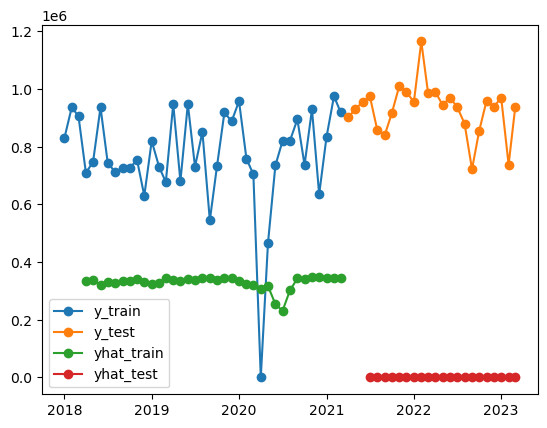

district_no 3
Epoch 1/20


2023-04-03 23:37:31.224703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:32.198851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:32.564701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:32.900257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:33.361757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:33.780837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:37:34.206478: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 11s 88ms/step - loss: 0.1234
Epoch 2/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1139
Epoch 3/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1153
Epoch 4/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1136
Epoch 5/20
36/36 [==============================] - 2s 44ms/step - loss: 0.1143
Epoch 6/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1116
Epoch 7/20
36/36 [==============================] - 2s 45ms/step - loss: 0.1137
Epoch 8/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1127
Epoch 9/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1119
Epoch 10/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1115
Epoch 11/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1118
Epoch 12/20
36/36 [==============================] - 2s 42ms/step - loss: 0.1116
Epoch 13/20
36/36 [============================

2023-04-03 23:38:08.670913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:09.224550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:09.493191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:09.837346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 87057.48 RMSE
Test Score: 189885.20 RMSE


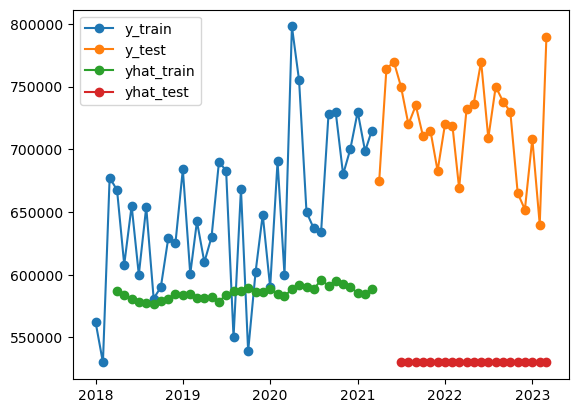

district_no 4
Epoch 1/20


2023-04-03 23:38:19.517528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:20.536798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:20.931710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:21.341945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:21.899658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:22.348283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:38:22.819020: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 12s 107ms/step - loss: 0.0906
Epoch 2/20
36/36 [==============================] - 2s 48ms/step - loss: 0.0856
Epoch 3/20
36/36 [==============================] - 2s 48ms/step - loss: 0.0856
Epoch 4/20
36/36 [==============================] - 2s 46ms/step - loss: 0.0862
Epoch 5/20
36/36 [==============================] - 2s 51ms/step - loss: 0.0863
Epoch 6/20
36/36 [==============================] - 2s 56ms/step - loss: 0.0850
Epoch 7/20
36/36 [==============================] - 2s 45ms/step - loss: 0.0852
Epoch 8/20
36/36 [==============================] - 2s 47ms/step - loss: 0.0847
Epoch 9/20
36/36 [==============================] - 2s 46ms/step - loss: 0.0847
Epoch 10/20
36/36 [==============================] - 2s 46ms/step - loss: 0.0845
Epoch 11/20
36/36 [==============================] - 2s 44ms/step - loss: 0.0853
Epoch 12/20
36/36 [==============================] - 2s 54ms/step - loss: 0.0848
Epoch 13/20
36/36 [===========================

2023-04-03 23:39:02.730975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:03.312905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:03.598194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:03.892759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 17ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 107976.97 RMSE
Test Score: 269154.34 RMSE


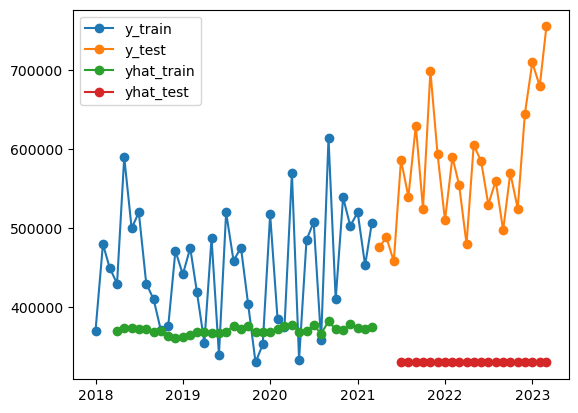

district_no 5
Epoch 1/20


2023-04-03 23:39:14.266754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:15.315139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:15.791826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:16.161455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:16.783931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:17.223547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:17.662923: I tensorflow/core/grappler/optimizers/cust

36/36 [==============================] - 12s 100ms/step - loss: 0.1253
Epoch 2/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1079
Epoch 3/20
36/36 [==============================] - 2s 46ms/step - loss: 0.1061
Epoch 4/20
36/36 [==============================] - 2s 48ms/step - loss: 0.1050
Epoch 5/20
36/36 [==============================] - 2s 48ms/step - loss: 0.1050
Epoch 6/20
36/36 [==============================] - 1s 41ms/step - loss: 0.1041
Epoch 7/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1042
Epoch 8/20
36/36 [==============================] - 1s 40ms/step - loss: 0.1044
Epoch 9/20
36/36 [==============================] - 2s 46ms/step - loss: 0.1043
Epoch 10/20
36/36 [==============================] - 2s 48ms/step - loss: 0.1039
Epoch 11/20
36/36 [==============================] - 2s 48ms/step - loss: 0.1037
Epoch 12/20
36/36 [==============================] - 2s 43ms/step - loss: 0.1033
Epoch 13/20
36/36 [===========================

2023-04-03 23:39:54.235051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:54.839880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:55.129601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:39:55.410837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 16ms/step
yhat train shape (36, 9)
yhat test shape (21, 9)
y train shape (36,)
y test shape (21,)
Train Score: 83538.35 RMSE
Test Score: 245152.33 RMSE


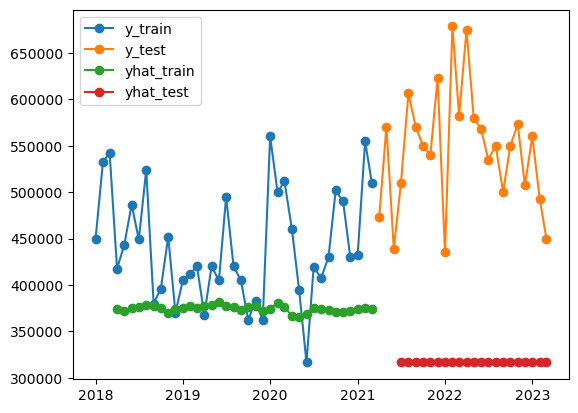

district_no 7
Epoch 1/20


2023-04-03 23:40:05.788695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:06.841522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:07.288678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:07.697888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:08.232026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:08.690868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-03 23:40:09.139396: I tensorflow/core/grappler/optimizers/cust

16/36 [============>.................] - ETA: 5s - loss: 0.2384

KeyboardInterrupt: 

In [155]:
# run the model for all districts
district_no_list = list(train_lstm_df_dict.keys())
test_score_dict = {}
for district_no in district_no_list:
    print("district_no", district_no)
    model = fit_lstm(train_lstm_dataset_dict[district_no])
    test_score = evaluate_lstm(
        model=model,
        X_train=train_lstm_dataset_dict[district_no],
        X_test=test_lstm_dataset_dict[district_no],
        district_no=district_no,
        lookback=lookback,
    )           
    test_score_dict[district_no] = test_score       